In [1]:
import numpy
import cv2

In [2]:
import random

In [3]:
import matplotlib.pyplot as plt

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

In [5]:
import torch
from torch import nn

In [6]:
from fastai.vision.all import *

In [7]:
class custom_dataset(Dataset):
    def __init__(self,n):
        self.n = n
        pass
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        img = numpy.zeros((300,300,3))
        nc_rgb = {0:0,1:0,2:0}
        for nc in range(random.randint(5,14)):
            cx = random.randint(30,270)
            cy = random.randint(30,270)
            center_coordinates = (cx, cy)
            radius = random.randint(5,20)
            # color in RGB
            color = [0,0,0]
            color_idx = random.randint(0,2)
            color[color_idx] = 1
            nc_rgb[color_idx] += 1
            thickness = -1
            image = cv2.circle(img, center_coordinates, radius, color, thickness)
        k =  random.randint(0,2)
        image = torch.Tensor(image).permute(2,1,0)
        return (image,k), torch.tensor(nc_rgb[k],dtype=torch.float32)

In [8]:
batch_size = 128

In [9]:
train_dataloader = DataLoader(custom_dataset(8196), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(custom_dataset(1024), batch_size=batch_size, shuffle=True)

In [10]:
def show_batch(train_features, train_labels):
    figure = plt.figure(figsize=(7, 7))
    cols, rows = 3,3
    for i in range(1, cols * rows + 1):
        label =  train_labels[i]
        img, img_mt = train_features[0][i], train_features[1][i]
        figure.add_subplot(rows, cols, i)
        plt.title(f"{label.item():.2f}, {img_mt}")
        plt.axis("off")
        plt.imshow(img.permute(2,1,0))
    plt.show()

In [11]:
class custom_model(nn.Module):
    def __init__(self):
        super(custom_model, self).__init__()
        self.conv_layers = nn.Sequential(
        nn.Conv2d(3, 8, 3),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 16, 3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, 3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, 3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, 3, stride=2),
        nn.ReLU(),
        )
        self.linear = nn.Linear(9249,1,bias=True)
        
    def forward(self, x):
        mt = x[1]
        x = x[0]
        x = self.conv_layers(x)
        x = x.view(x.shape[0],-1)
        x = torch.cat([x,mt.unsqueeze(1)],dim=1)
        x = self.linear(x).squeeze(1)
        return x

In [ ]:
model = custom_model()

In [57]:
model.load_state_dict(torch.load('nn_mt_model_weights.pth'))

<All keys matched successfully>

In [58]:
print("Model structure: ", model, "\n\n")

Model structure:  custom_model(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (13): ReLU()
  )
  (linear): Linear(in_features=9249, out_features=1, bias=True)
) 




In [11]:
learning_rate = 1e-2

In [60]:
loss_fn = nn.MSELoss()

In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [62]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.to(device), y.float().to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y = y.float().to(device)
            test_loss += loss_fn(pred.to(device), y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [63]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
torch.Size([64, 1])


NameError: name 'device' is not defined

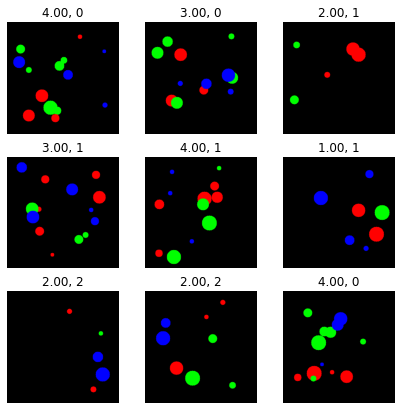

In [45]:
test_features, test_labels = next(iter(test_dataloader))
show_batch(test_features, test_labels)

In [12]:
def show_preds(train_features, pred_labels, exp_labels ):
    figure = plt.figure(figsize=(7, 7))
    cols, rows = 3,3
    for i in range(1, cols * rows + 1):
        label =  pred_labels[i]
        img, img_mt = train_features[0][i], train_features[1][i]
        figure.add_subplot(rows, cols, i)
        plt.title(f"{label.item():.2f}, exp:{exp_labels[i]}, {img_mt}")
        plt.axis("off")
        plt.imshow(img.detach().permute(2,1,0))
    plt.show()

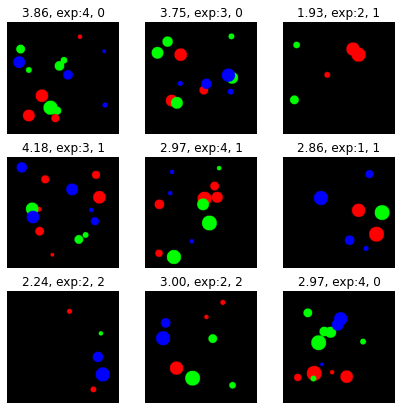

In [81]:
model.eval()
show_preds(test_features, model(test_features),test_labels)

In [82]:
torch.save(model.state_dict(), 'nn_mt_model_weights.pth')

In [98]:
x, y = next(iter(test_dataloader))

In [113]:
x[1]

tensor([0, 2, 0, 2, 2, 2, 1, 0, 0, 0, 1, 2, 1, 0, 1, 2, 1, 2, 0, 2, 1, 0, 1, 2,
        0, 0, 0, 1, 0, 2, 2, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1, 1,
        2, 2, 0, 0, 1, 0, 2, 0, 0, 2, 0, 2, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 0, 1,
        2, 0, 1, 2, 0, 0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 2, 1, 2, 0, 2, 1, 0, 0, 1, 2, 2, 1, 1, 2, 1, 1, 0, 2, 0, 1, 2, 0, 1,
        0, 2, 1, 2, 2, 0, 2, 2])

In [165]:
im = x[0][41]

In [166]:
mt = x[1][0].unsqueeze(0)

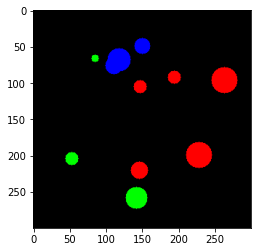

In [167]:
plt.imshow(im.permute(2,1,0))

### Fastai learner class 

In [13]:
data = DataLoaders(train_dataloader, test_dataloader, device='cuda')

In [14]:
learn = Learner(data, custom_model(), loss_func=F.mse_loss, opt_func=Adam)

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.0003311311302240938)

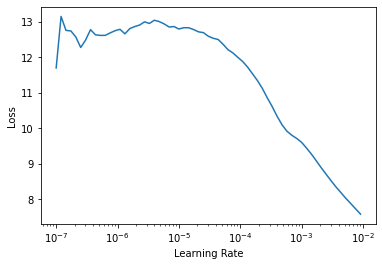

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,time
0,4.283502,2.926250,00:28
1,2.736741,2.435125,00:26
2,2.521677,4.026369,00:26
3,2.477758,3.459149,00:26
4,2.374569,3.782008,00:26
5,2.392248,2.481993,00:26
6,2.402879,2.911052,00:26
7,2.411569,2.316611,00:26
8,2.365647,2.641708,00:26
9,2.357537,2.393522,00:26


In [19]:
learn = learn.load('nn_metadata_fai_model.pth',device='cpu')

In [16]:
learn.save('nn_metadata_fai_model_8k.pth')

Path('models/nn_metadata_fai_model_8k.pth.pth')

In [17]:
test_features, test_labels = next(iter(test_dataloader))

In [21]:
show_preds(test_features, learn.model(test_features).cpu(),test_labels.cpu())

RuntimeError: CUDA out of memory. Tried to allocate 348.00 MiB (GPU 0; 3.79 GiB total capacity; 2.30 GiB already allocated; 46.00 MiB free; 2.55 GiB reserved in total by PyTorch)

In [27]:
x, y = next(iter(test_dataloader))
im = x[0][70]
mt = x[1][0].unsqueeze(0)

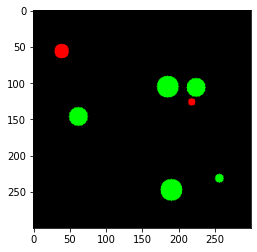

In [28]:
plt.imshow(im.cpu().permute(2,1,0))

In [29]:
#Red
mt[0] = 0
print(learn.model([im.unsqueeze(0),mt]).item(),mt.item())

2.7149431705474854 0


In [30]:
#Green
mt[0] = 1
print(learn.model([im.unsqueeze(0),mt]).item(),mt.item())

2.7147574424743652 1


In [31]:
#Blue
mt[0] = 2
print(learn.model([im.unsqueeze(0),mt]).item(),mt.item())

2.714571952819824 2
